# CI2 related figures

This notebook allows to recreate all figures in the manuscript related to CI2 from the provided experimental and calculated relaxation rates.

In [1]:
import ABSURDer as absurder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Patch
from matplotlib.lines import Line2D
import pickle
import scipy.stats as scs
import pandas as pd
import seaborn as sns

In [2]:
def load( inp ):
    pin = open( inp, 'rb' )
    return pickle.load( pin )

In [3]:
def _chi2_nomderr( rex, eex, rmd, r, w):

    rrw = np.dot( rmd, w[:,np.newaxis] )[:,:,0] #removes last, useless axis
    if r == -1:
        er2 = eex**2
        return np.sum( (rex - rrw)**2 / er2 )
    else:
        er2 = eex[r]**2
        return np.sum( (rex[r] - rrw[r])**2 / er2 )
       
def chi2r_nomderr(rex, eex, rmd, r, w='initw'):

    if w=='initw':
        w = np.array([ 1/rmd.shape[-1] for i in range(rmd.shape[-1])])
        
    if r == -1:
        x2 = _chi2_nomderr( rex, eex, rmd, r, w )
        return x2 / ( rex.shape[1] * rex.shape[0] )
    else:
        x2 = _chi2_nomderr( rex, eex, rmd, r, w )
        return x2 / rex.shape[1]              

In [4]:
def get_corr(rex, rmd, r):
    if r == -1:
        return np.corrcoef(rex.flatten(), np.average(rmd, axis=-1).flatten())[0,1]
    else:
        return np.corrcoef(rex[r,:], np.average(rmd, axis=-1)[r,:])[0,1]

In [5]:
rate_colors = [ '#ffc857', '#084c61', '#db3a34', '#177e89', '#2c6e49', '#323031']
labels     = [ r'$R(D_z)$', r'$R(D_y)$', r'$R(3D_z^2-2)$', r'$R(D_y^2)$' ]
l_hms = 'HMS'
l_cgcorr = r'C$^{\gamma}_{\rm corr.}$'

In [6]:
mlist = '../data/exp/ci2/nmr_methyls.pkl'
rex   = '../data/exp/ci2/nmr_r1r2r3r4_rates_yg.npy'
eex   = '../data/exp/ci2/nmr_r1r2r3r4_errors_yg.npy'

In [7]:
nmr_methyls = load(mlist)
nmr_rates   = np.load(rex) 
nmr_errors  = np.load(eex)

In [8]:
cgcorr = [i for i,ii in enumerate(nmr_methyls) if 'G' in ii]
no_cgcorr = [i for i,ii in enumerate(nmr_methyls) if 'G' not in ii]

In [9]:
rmd_cgcorr  = load('../data/calc/ci2/deltak_CgCorr/rmd.pkl')
ravg_cgcorr = np.average(rmd_cgcorr, axis=-1)

rmd_hms  = load('../data/calc/ci2/deltak_HMS/rmd.pkl')
ravg_hms = np.average(rmd_hms, axis=-1)

# Fig. 2A-D

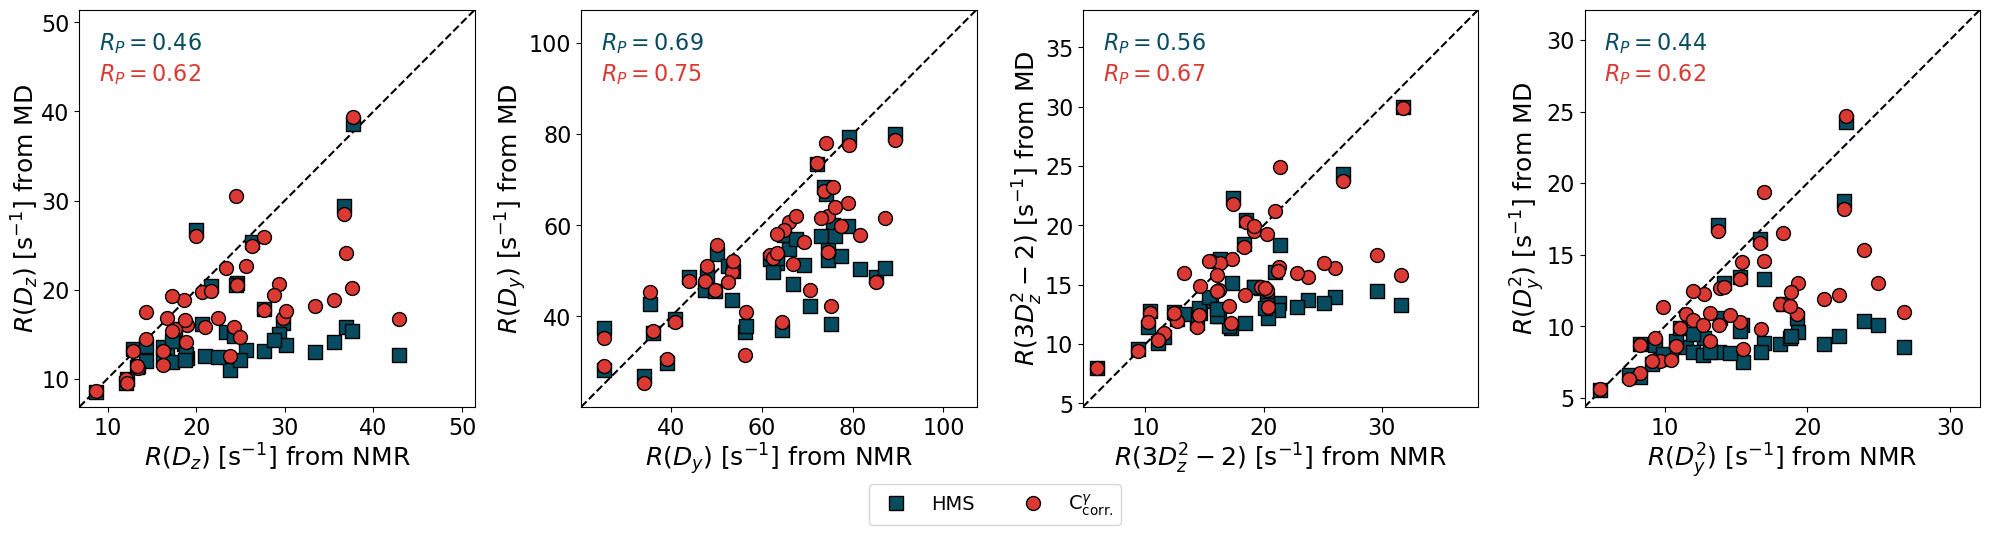

In [10]:
fig = plt.figure(figsize=[20,5])
for r in range(nmr_rates.shape[0]):
    rp = []
    rp.append(np.corrcoef(nmr_rates[r,:], ravg_hms[r,:])[0,1])
    rp.append(np.corrcoef(nmr_rates[r,:], ravg_cgcorr[r,:])[0,1])
    
    ax = plt.subplot(1,4,r+1)
    plt.scatter(nmr_rates[r,:], ravg_hms[r,:], marker='s', color=rate_colors[1], s=90, edgecolor='k')
    plt.scatter(nmr_rates[r,:], ravg_cgcorr[r,:], marker='o', color=rate_colors[2], s=100, edgecolor='k')
    xymin = np.min([nmr_rates[r,:], ravg_hms[r,:]])*0.8
    xymax = np.max([nmr_rates[r,:], ravg_cgcorr[r,:]])*1.2
    plt.plot([xymin,xymax], [xymin,xymax], ls='--', c='k', zorder=-1)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.xlabel(f'{labels[r]} [s$^{{-1}}$] from NMR', fontsize=18, labelpad=1)
    plt.ylabel(f'{labels[r]} [s$^{{-1}}$] from MD', fontsize=18, labelpad=0.001)
    
    plt.text(0.05, 0.9, f'$R_P={rp[0]:.2f}$', fontsize=16, weight=1000, transform=ax.transAxes, color=rate_colors[1]) #, $\chi^2={chi2[1]:.2f}$
    plt.text(0.05, 0.82, f'$R_P={rp[1]:.2f}$', fontsize=16, weight=1000, transform=ax.transAxes, color=rate_colors[2])  #, $\chi^2={chi2[2]:.2f}$
    
    custom_handles = [Line2D([0], [0], marker='s', ls='', color=rate_colors[1], markeredgecolor='k', markersize=10, label=l_hms),
                      Line2D([0], [0], marker='o', ls='', color=rate_colors[2], markeredgecolor='k', markersize=10, label=l_cgcorr)]
lgd = fig.legend(handles=custom_handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.08))#, handletextpad=0.001)

fig.tight_layout()
fig.savefig('../plots/ci2/fig2_a_b_c_d.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.show()

# Fig. 2E

In [11]:
methyl_types = sorted(list(set(i.split('-')[-1] for i in nmr_methyls)))
tmp_labels = [r'All']+labels

chi2s_cgcorr_nomderr = []
chi2s_hms_nomderr   = []
for r in [-1,0,1,2,3]:
    tmp_chi2s_cgcorr_nomderr = []
    tmp_chi2s_hms_nomderr   = []
    for mt in [cgcorr, no_cgcorr]:
        idxs =  mt
        tmp_chi2s_cgcorr_nomderr.append( chi2r_nomderr(nmr_rates[:,idxs], nmr_errors[:,idxs], rmd_cgcorr[:,idxs,:], r) )
        tmp_chi2s_hms_nomderr.append( chi2r_nomderr(nmr_rates[:,idxs], nmr_errors[:,idxs], rmd_hms[:,idxs,:], r) )

    chi2s_cgcorr_nomderr.append(tmp_chi2s_cgcorr_nomderr)
    chi2s_hms_nomderr.append(tmp_chi2s_hms_nomderr)  
    
chi2s_cgcorr_nomderr, chi2s_hms_nomderr = np.array(chi2s_cgcorr_nomderr), np.array(chi2s_hms_nomderr)

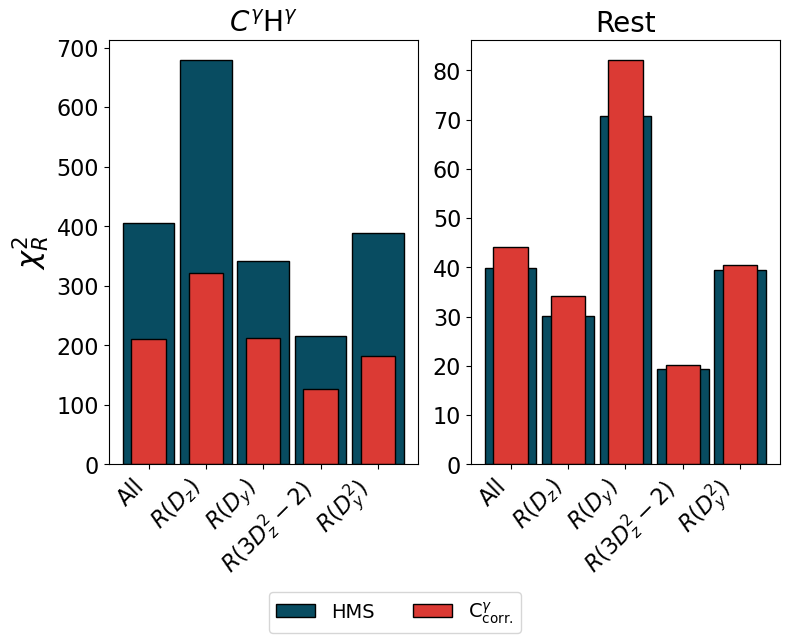

In [12]:
fig = plt.figure(figsize=[8,6])

for r,rr in enumerate([r'$C^{\gamma}$H$^{\gamma}$', 'Rest']):
    plt.subplot(1,2,r+1)
    plt.bar(tmp_labels, chi2s_hms_nomderr[:,r], width=0.9, color=rate_colors[1], edgecolor='k', linewidth=1, label='Orig. ff')
    plt.bar(tmp_labels, chi2s_cgcorr_nomderr[:,r], width=0.6, color=rate_colors[2], edgecolor='k', linewidth=1, label='corr. ff')
    if r==0:
        plt.ylabel('$\chi^2_R$', fontsize=22)
    plt.xticks(rotation=45, ha='right')
    plt.title(rr, fontsize=20)

custom_handles = [Patch(facecolor=rate_colors[1], edgecolor='k', label=l_hms),
                  Patch(facecolor=rate_colors[2], edgecolor='k', label=l_cgcorr)]
lgd = fig.legend(handles=custom_handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
fig.savefig('../plots/ci2/fig2_e.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Fig. 2F-G

In [13]:
# for idx,methyl in enumerate(nmr_methyls): # for all methyls
for methyl in ['ILE37-CG2HG2', 'VAL19-CG1HG1']:
    idx = nmr_methyls.index(methyl)
    if 'G' in methyl: # filter only Cg
        fig = plt.figure(figsize=[13,3])
        for r in range( rmd_hms.shape[0] ):
            x      = np.linspace( rmd_hms[r, idx, :].min(), rmd_hms[r, idx, :].max(), num=100 )
            kde_hms = scs.gaussian_kde( rmd_hms[r, idx, :], bw_method='silverman' )
            kde_hms.set_bandwidth( kde_hms.scotts_factor()/1.5 )
            kde_hms = kde_hms.evaluate( x )

            x2      = np.linspace( rmd_cgcorr[r, idx, :].min(), rmd_cgcorr[r, idx, :].max(), num=100 )
            kde_cgcorr = scs.gaussian_kde( rmd_cgcorr[r, idx, :], bw_method='silverman' )
            kde_cgcorr.set_bandwidth( kde_cgcorr.scotts_factor()/1.5 )
            kde_cgcorr = kde_cgcorr.evaluate( x2 )

            my = max([max(kde_hms), max(kde_cgcorr)])
            my += 0.05 * my

            plt.subplot(1, rmd_hms.shape[0], r+1)

            plt.plot( x, kde_hms, lw=3, color=rate_colors[1], zorder=-10 )
            plt.fill_between( x, kde_hms, color=rate_colors[1], alpha=0.3, label='MD hms. ff' )
            plt.vlines( ravg_hms[r, idx], 0, my, color=rate_colors[1], lw=4, linestyle=':', zorder=10, label='Avg. MD hms. ff' )

            plt.plot( x2, kde_cgcorr, lw=3, color=rate_colors[2], zorder=-10)
            plt.fill_between( x2, kde_cgcorr, color=rate_colors[2], alpha=0.3, label='MD optim. ff' )
            plt.vlines( ravg_cgcorr[r, idx], 0, my, color=rate_colors[2], lw=4, linestyle='--', zorder=5, label = 'Avg. MD optim. ff' )

            plt.vlines( nmr_rates[r, idx], 0, my, lw=3, zorder=1, label='NMR', color='k')
            plt.axvspan( nmr_rates[r, idx]-nmr_errors[r, idx], nmr_rates[r, idx]+nmr_errors[r, idx], 0.05, 0.96, color='k', alpha=0.4, zorder=0 )

            label = labels[r] + r' [s$^{-1}$]'
            plt.xlabel(label)
            if r == 0:
                plt.ylabel('p(R)')

            plt.suptitle(methyl, fontsize=18)
    
        plt.tight_layout()#rect=[0, 0, 1, 1.03], w_pad=0.01)
        plt.savefig(f'../plots/ci2/fig2_f_g_{methyl}.pdf')
        plt.show()
    else:
        continue


NameError: name 'kde_cgcorr' is not defined

<Figure size 1300x300 with 0 Axes>

# Fig. S2A-D

In [ ]:
fig = plt.figure(figsize=[10,10])
for r in range(nmr_rates.shape[0]):
    plt.subplot(2,2,r+1)
    plt.scatter(ravg_hms[r,cgcorr], ravg_cgcorr[r,cgcorr], marker='o', color=rate_colors[-1], s=75, edgecolor='k', label=f'C$^\gamma$H$^\gamma$: $R_P={np.corrcoef(ravg_hms[r,cgcorr], ravg_cgcorr[r,cgcorr])[0,1]:.3f}$', zorder=10)
    plt.scatter(ravg_hms[r,no_cgcorr], ravg_cgcorr[r,no_cgcorr], marker='s', color='lightgrey', s=70, edgecolor='k', label=f'Rest: $R_P={np.corrcoef(ravg_hms[r,no_cgcorr], ravg_cgcorr[r,no_cgcorr])[0,1]:.3f}$')
    xymin = np.min([ravg_cgcorr[r,:], ravg_hms[r,:]])*0.8
    xymax = np.max([ravg_cgcorr[r,:], ravg_hms[r,:]])*1.2
    plt.plot([xymin,xymax], [xymin,xymax], ls='--', c='k', zorder=-1)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.title(f'{labels[r]} [s$^{{-1}}$]', fontsize=18)
    plt.xlabel(l_hms, fontsize=18, labelpad=1)
    plt.ylabel(l_cgcorr, fontsize=18, labelpad=0.001)
    plt.legend(fontsize=14, handletextpad=0.001)

fig.tight_layout(h_pad=4, w_pad=5)
plt.savefig('../plots/ci2/figs2_a_b_c_d.pdf')
fig.show()

# Fig. S4B

In [ ]:
meth_sd = pd.DataFrame(columns=['lbl', 'std'])
for meth in ['CB', 'CG', 'CD1', 'CD2']: # sorted
    idxs = [ i for i,ii in enumerate(nmr_methyls) if meth in ii ]
    for i,d in enumerate([rmd_hms, rmd_cgcorr]):
        tmp_df = pd.DataFrame(columns=['lbl', 'std'])
        tmp_df['std'] = np.std(d[:,idxs,:], axis=-1).flatten()
        tmp_df['lbl'] = [f'{meth}']*len(tmp_df)
        tmp_df['ff'] = [f'{i}']*len(tmp_df)
        meth_sd = pd.concat([meth_sd, tmp_df])

In [ ]:
custom_handles = [  Patch(facecolor=rate_colors[1], edgecolor=rate_colors[-1], linewidth=1.5, label=r'HMS'),
                    Patch(facecolor=rate_colors[2], edgecolor=rate_colors[-1], linewidth=1.5, label=r'C$^{\rm \gamma}_{\rm corr.}$') ]

plt.figure(figsize=[7,5])

ax = sns.boxplot(x="lbl", y="std", data=meth_sd, showfliers=False, hue='ff', width=0.8, linewidth=2, palette=[rate_colors[1], rate_colors[2]], saturation=1)
ax = sns.swarmplot(x="lbl", y="std", data=meth_sd, color="0.", alpha=1, hue='ff', dodge=True, size=3)

ax.set_xticklabels([r'C$^{\rm \beta}$H$^{\rm \beta}$', r'C$^{\rm \gamma}$H$^{\rm \gamma}$', r'C$^{\rm \delta1}$H$^{\rm \delta1}$', r'C$^{\rm \delta2}$H$^{\rm \delta2}$'])
plt.xlabel(None)
plt.ylabel('std.')
plt.title('CI2', fontsize=18)
leg = plt.legend(handles=custom_handles, loc='best', ncol=1)
plt.tight_layout()
plt.savefig(f'../plots/ci2/figs4_b.pdf')
plt.show()